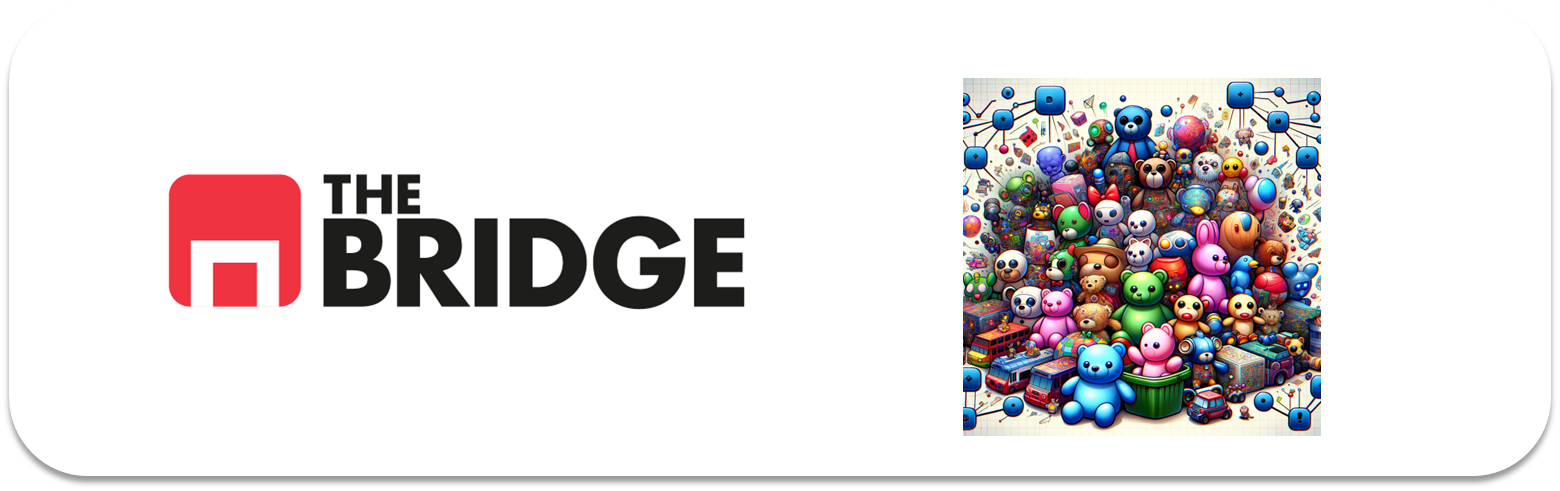

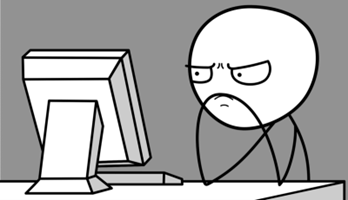

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
import numpy as np
import os

In [6]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [7]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [8]:
import pandas as pd

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [11]:
df_drugs=pd.read_csv('data/drugLibTrain_raw.tsv', sep = '\t')
df_drugs.head(5)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [13]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3107 non-null   int64 
 1   urlDrugName        3107 non-null   object
 2   rating             3107 non-null   int64 
 3   effectiveness      3107 non-null   object
 4   sideEffects        3107 non-null   object
 5   condition          3106 non-null   object
 6   benefitsReview     3089 non-null   object
 7   sideEffectsReview  3032 non-null   object
 8   commentsReview     3095 non-null   object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB


In [14]:
for col in df_drugs:
    print(col,df_drugs[col].nunique())

Unnamed: 0 3107
urlDrugName 502
rating 10
effectiveness 5
sideEffects 5
condition 1426
benefitsReview 3031
sideEffectsReview 2813
commentsReview 3046


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [16]:
cardinalidad={}
n=len(df_drugs)
for col in df_drugs:
    card=df_drugs[col].nunique()/n*100
    cardinalidad[col]=card
cardinalidad

{'Unnamed: 0': 100.0,
 'urlDrugName': 16.157064692629547,
 'rating': 0.32185387833923396,
 'effectiveness': 0.16092693916961698,
 'sideEffects': 0.16092693916961698,
 'condition': 45.89636305117477,
 'benefitsReview': 97.55391052462183,
 'sideEffectsReview': 90.53749597682652,
 'commentsReview': 98.03669134213068}

In [17]:
df=df_drugs.copy()

In [18]:
del df['Unnamed: 0']

In [19]:
del df['benefitsReview']

In [20]:
del df['condition']

In [21]:
del df['sideEffectsReview']

In [22]:
del df['commentsReview']

In [23]:
df.head(5)

,urlDrugName,rating,effectiveness,sideEffects
0,enalapril,4,Highly Effective,Mild Side Effects
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects
2,ponstel,10,Highly Effective,No Side Effects
3,prilosec,3,Marginally Effective,Mild Side Effects
4,lyrica,2,Marginally Effective,Severe Side Effects


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   urlDrugName    3107 non-null   object
 1   rating         3107 non-null   int64 
 2   effectiveness  3107 non-null   object
 3   sideEffects    3107 non-null   object
dtypes: int64(1), object(3)
memory usage: 97.2+ KB


In [29]:
for col in df:
    print(f"{col} tiene nunique: {df[col].nunique()}")

urlDrugName tiene nunique: 502
rating tiene nunique: 10
effectiveness tiene nunique: 5
sideEffects tiene nunique: 5


In [36]:
for col in df:
    if col != 'urlDrugName':
        print(f"{col} tiene nunique: {df[col].unique()}\n")

rating tiene nunique: [ 4  1 10  3  2  9  7  8  6  5]

effectiveness tiene nunique: ['Highly Effective' 'Marginally Effective' 'Ineffective'
 'Considerably Effective' 'Moderately Effective']

sideEffects tiene nunique: ['Mild Side Effects' 'Severe Side Effects' 'No Side Effects'
 'Extremely Severe Side Effects' 'Moderate Side Effects']



In [38]:
#Quitamos urlDrugName como dice el enunciado
del df['urlDrugName']

In [39]:
df.describe(include= 'all')

,rating,effectiveness,sideEffects
count,3107.000000,3107,3107
unique,NaN,5,5
top,NaN,Highly Effective,Mild Side Effects
freq,NaN,1330,1019
mean,7.006115,NaN,NaN
std,2.937582,NaN,NaN
min,1.000000,NaN,NaN
25%,5.000000,NaN,NaN
50%,8.000000,NaN,NaN
75%,9.000000,NaN,NaN


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [40]:
X=df.copy()

In [41]:
X.head()

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects


In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         3107 non-null   int64 
 1   effectiveness  3107 non-null   object
 2   sideEffects    3107 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.9+ KB


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [45]:
list(X.effectiveness.unique())

['Highly Effective',
 'Marginally Effective',
 'Ineffective',
 'Considerably Effective',
 'Moderately Effective']

In [47]:
mapeado_effectiveness={'Highly Effective':4,'Marginally Effective':1,'Ineffective':0,'Considerably Effective':3,'Moderately Effective':2}

In [48]:
list(X.sideEffects.unique())

['Mild Side Effects',
 'Severe Side Effects',
 'No Side Effects',
 'Extremely Severe Side Effects',
 'Moderate Side Effects']

In [49]:
mapeado_sideEffects={'Extremely Severe Side Effects':4,'Mild Side Effects':1,'No Side Effects':0,'Severe Side Effects':3,'Moderate Side Effects':2}

In [50]:
X['effectiveness']=X['effectiveness'].map(mapeado_effectiveness)
X['sideEffects']=X['sideEffects'].map(mapeado_sideEffects)

In [51]:
X.head()

,rating,effectiveness,sideEffects
0,4,4,1
1,1,4,3
2,10,4,0
3,3,1,1
4,2,1,3


In [52]:
X.info() #Ahora son todos números

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   rating         3107 non-null   int64
 1   effectiveness  3107 non-null   int64
 2   sideEffects    3107 non-null   int64
dtypes: int64(3)
memory usage: 72.9 KB


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

In [53]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X[X.columns] = minmax.fit_transform(X)

In [54]:
X.describe()

,rating,effectiveness,sideEffects
count,3107.000000,3107.000000,3107.000000
mean,0.667346,0.733907,0.326199
std,0.326398,0.307633,0.294371
min,0.000000,0.000000,0.000000
25%,0.444444,0.500000,0.000000
50%,0.777778,0.750000,0.250000
75%,0.888889,1.000000,0.500000
max,1.000000,1.000000,1.000000


In [55]:
X.head()

,rating,effectiveness,sideEffects
0,0.333333,1.00,0.25
1,0.000000,1.00,0.75
2,1.000000,1.00,0.00
3,0.222222,0.25,0.25
4,0.111111,0.25,0.75


In [57]:
import seaborn as sns

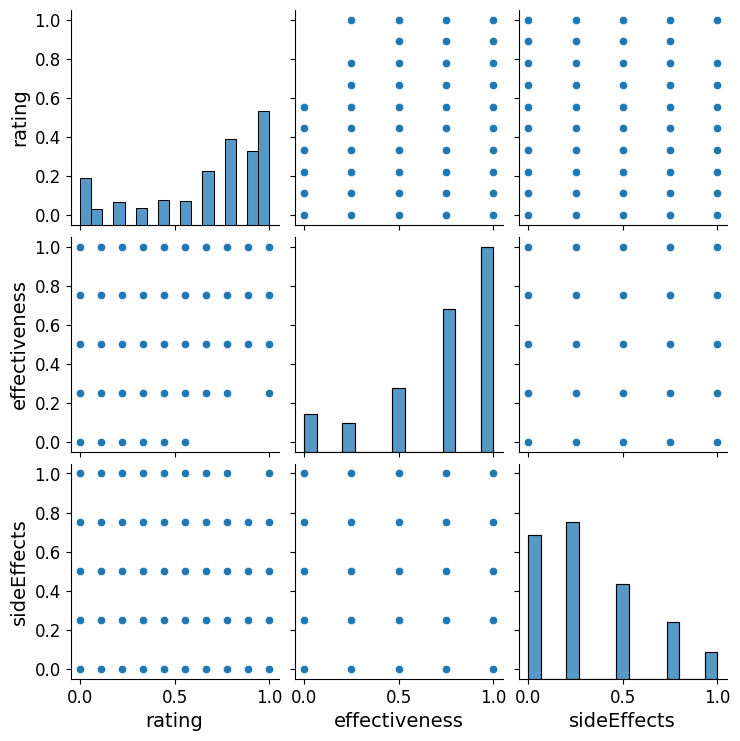

In [61]:
sns.pairplot(X)

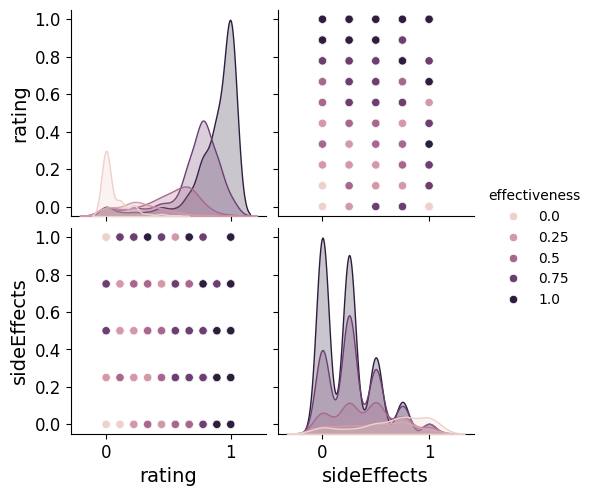

In [62]:
sns.pairplot(X, hue = "effectiveness")

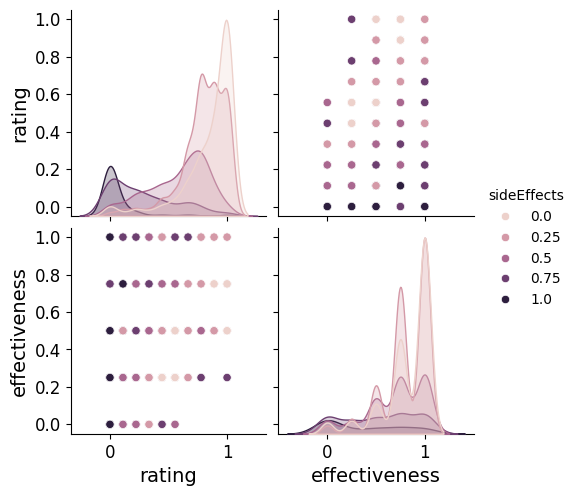

In [63]:
sns.pairplot(X, hue = "sideEffects")

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [74]:
ks = []
inertias = []

for k in range(1, 10):
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    ks.append(k)

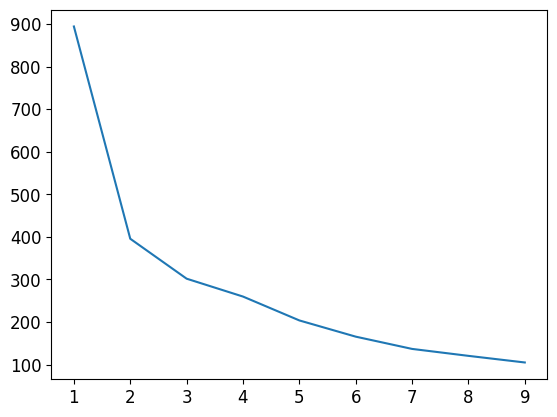

In [72]:
plt.plot(ks, inertias);

Está claro que es K=2 o K=3

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [76]:
sil_scores = []

for k in ks[1:]: 
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)

    sil_scores.append(silhouette_score(X, clustering.labels_))

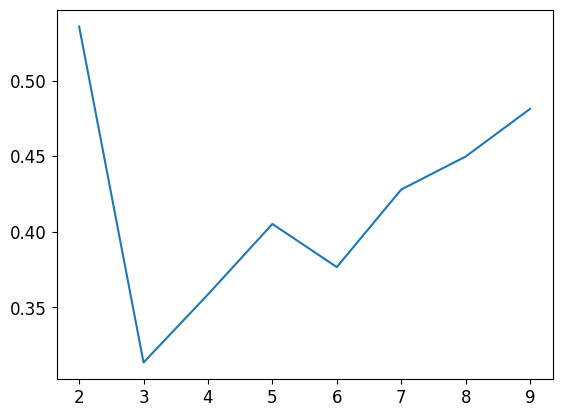

In [77]:
plt.plot(ks[1:], sil_scores);

Se Maximiza con K=2

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

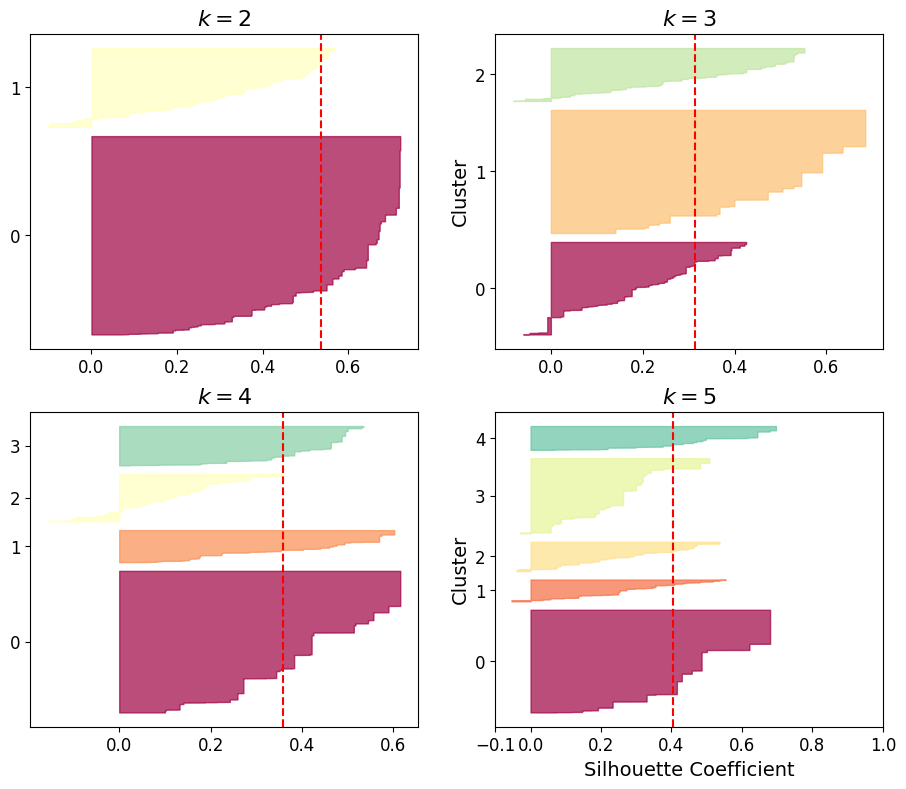

In [79]:
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib
'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    clustering = KMeans(n_clusters = k)
    clustering.fit(X)
    y_pred = clustering.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=sil_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

Se ve que K=2 y K=3 tienen algun score negativo, lo cual significa que hay datos 'mal' clasificados, el K=3 la distribución en clusteres es más equilibrada que en K=2. 

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [80]:
clustering_k2 = KMeans(n_clusters= 2)
clustering_k2.fit(X)

KMeans(n_clusters=2)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [81]:
X['cluster'] = clustering_k2.predict(X)
X.head()

,rating,effectiveness,sideEffects,cluster
0,0.333333,1.00,0.25,1
1,0.000000,1.00,0.75,0
2,1.000000,1.00,0.00,1
3,0.222222,0.25,0.25,0
4,0.111111,0.25,0.75,0


In [82]:
X['cluster'].value_counts(normalize= True)

cluster
1    0.715481
0    0.284519
Name: proportion, dtype: float64

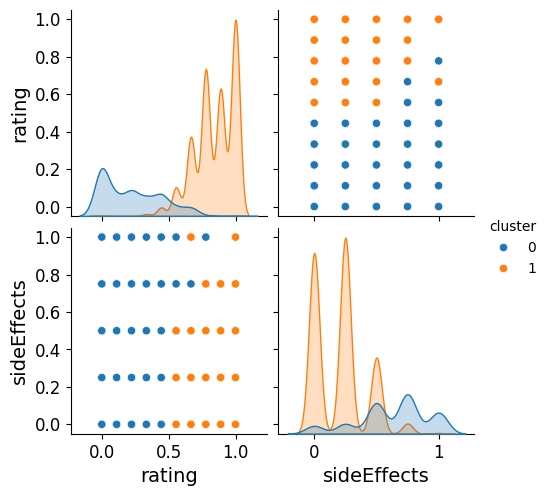

In [83]:
sns.pairplot(data= X[['rating', 'sideEffects', 'cluster']], hue= 'cluster');

Parece que el cluster 0 es de rating bajo y cluster 1 de rating alto

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

Comprobamos como quedaría para K=3

In [93]:
X=df.copy()
X['effectiveness']=X['effectiveness'].map(mapeado_effectiveness)
X['sideEffects']=X['sideEffects'].map(mapeado_sideEffects)
X[X.columns] = minmax.fit_transform(X)

In [94]:
clustering_k3 = KMeans(n_clusters= 3)
clustering_k3.fit(X)

KMeans(n_clusters=3)

In [95]:
X['3cluster'] = clustering_k3.predict(X)
X.head()

,rating,effectiveness,sideEffects,3cluster
0,0.333333,1.00,0.25,2
1,0.000000,1.00,0.75,1
2,1.000000,1.00,0.00,0
3,0.222222,0.25,0.25,1
4,0.111111,0.25,0.75,1


In [96]:
X['3cluster'].value_counts(normalize= True)

3cluster
0    0.458320
2    0.342453
1    0.199228
Name: proportion, dtype: float64

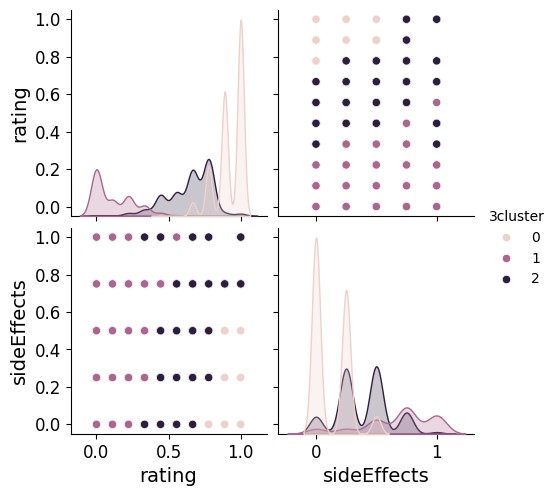

In [97]:
sns.pairplot(data= X[['rating', 'sideEffects', '3cluster']], hue= '3cluster');